In [1]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
%matplotlib inline

#                                          FEATURE SELECTION

## 1. Définitions
- La sélection d'attributs est le processus qui permet de sélectionner un sous ensemble d'attributs pertinents (pour la construction d'un modèle) parmi l'ensemble des attributs disponibles. 
- Un algorithme de sélection d'attributs est une combinaison de technique de recherche du sous ensemble associée avec une métrique d'évaluation qui mesure la pertinence du sous ensemble. Le choix de la métrique a un grand impact sur le sous ensemble sélectionné.

## 2. Qualité des attributs
Il est important de pouvoir estimer l'utilité d'un attribut ou d'un sous ensemble d'attributs. Pour cela, deux approches sont possibles :
- point de vue Statistique : utilisation des tests statistiques Z-test, T-test, ANOVA, ... (approche par filtre)
- point de vue Apprentissage Automatique : utilisation de la validation croisée

## 3. Interêt de la sélection d'attributs
Les attributs peuvent être redondants (corrélation) ou non pertinents (bruit).

Il existe deux cas importants où la sélection d'attributs est souhaitée:
- On s'interesse uniquement aux attributs, on veut savoir lesquels sont pertinents (on ne souhaite pas faire de prédiction). Exemple : quelles sont les raisons(attributs) qui peuvent causer un cancer?
- On s'interesse à la prédiction : l'interprétation des attributs n'est pas importante en soi, on souhaite construire le meilleur modèle prédictif.
En général, si le nombre d'attributs n'est pas très grand, il n'est pas nécessaire de faire une sélection d'attributs (certains algorithmes font une selection en interne : Lasso, arbres de décision, ...)

Si le temps d'exécution est important => faire une sélection au préalable.

La sélection d'attributs permet de:
- mieux interpréter le modèle en fournissant des explication simples grâce à des modèles simples
- un temps réduit d'apprentissage et de prédiction si le nombre d'attribut au départ est très grand.
- une meilleure généralization en réduisant les risques de surapprentissage

## 4. Techniques de sélection
- Filter methods (approche par filtres) : le choix des attributs se fait indépendemment de l'algorithme d'apprentissage. Le choix de l'attribut se fait sur base d'un critère propre au filtre (exemple : variance, Chi, information mutuelle ou corrélation avec l'attribut cible, ...).
Cette approche est rapide mais peut produire un sous ensemble d'attributs qui n'est pas optimal pour le modèle que'on souhaite construire.
Le plus grand désavantage de cette approche est que les attributs sont choisis indépendemment les uns des autres et ne tient donc pas compte des interractions possibles entre les attributs (un attribut non pertinent peut devenir pertinent s'il est combiné avec un autre attribut).


- Wrapper methods (approche symbiose) : utilise un modèle prédictif pour mesure la performance des sous ensembles d'attributs. L'algorithme d'apprentissage est utilisé comme une boite noire qui reçoit un sous ensemble d'attributs et retourne un score de validation en utilisant la validation croisée.
Cette technique est très couteuse puisqu'il faut tester tous les sous-ensembles possibles (avec n attributs, on a 2^n sous-ensemble possible), mais elle permet d'obtenir le meilleur sous-ensemble possible pour le modèle choisi (avec un risque de sur-apprentissage).
Tester 2^n possibilités est impossible en pratique. Pour contourner ce problème : 3 techniques peuvent être utilisées : random selection, forward selection et backward elimination.

- Embedded methods (approche intégrée) : se base uniquement sur l'algorithme d'apprentissage utilisé. Certains algorithmes sont capables au moment de l'apprentissage d'associer des poids aux attributs.
L'algorithme fait son apprentissage sur tous les attributs et la sélection se fait sur base des poids obtenus après apprentissage.
Par exemple, la technique de régularization LASSO associe un poids de zéro aux attributs non pertinents.


In [3]:
df = pd.read_csv('./ticdata2000.csv')
Y = df.label
X = df.drop(['label'], axis=1)
print (X.shape)
X.head()

dfValid = pd.read_csv('./ticdata2000_Validation.csv')
YValid = dfValid.label
XValid = dfValid.drop(['label'], axis=1)
print (XValid.shape)

(5822, 85)
(4000, 85)


In [4]:
#CHOIX DU MODELE A UTILISER
#Pour des raisons de simplicité et de rapidité d'exécution, j'ai choisi les arbres de décision
#Dans un vrai projet, il faudra tester différents modèles et voir quelle combinaison d'attributs/modèle donne
#les meilleurs performances

clf = DecisionTreeClassifier(random_state=1)
params = {'max_depth':[3,5,7,9],
          'min_samples_leaf' : [1,2,5]} #pour le gridSearch    
metric = 'roc_auc'

#nombre d'attributs à utiliser
n_features=20

In [5]:
#fonction d'apprentissage avec cross validation et gridsearch sur le premier dataset
def performance(X,Y):
    kf = StratifiedKFold(Y, n_folds=3, random_state=1)    
    gs = GridSearchCV(clf, params, scoring=metric, cv=kf)
    gs.fit(X,Y)
    return gs

#fonction de prédiction sur le dataset de validation
def validation(clf1, Xv, Yv):
    preds = clf1.predict_proba(Xv)[:,1]
    return roc_auc_score(Yv, preds)

gs = performance(X,Y)
print (gs.best_score_, gs.best_params_)

print (validation(gs.best_estimator_, XValid, YValid))

0.73225539246 {'min_samples_leaf': 1, 'max_depth': 5}
0.69475437703


In [136]:
#Approche filtre
def variance_selection(X,n_features):
    
    variance = [np.var(X[i]) for i in X.columns]
    variance = sorted( zip(variance,X.columns) ,reverse=True)[:n_features]   
        
    return [x[1] for x in variance]

for n_features in [5,10,15,20, 25, 30]:
    print n_features
    varFeatures = variance_selection(X,n_features)
    print 'Selected features : ', varFeatures
    gs = performance(X[varFeatures], Y)
    print gs.best_score_, gs.best_params_
    
    #print validation(gs.best_estimator_, XValid[varFeatures], YValid)
    print '***************************'

5
Selected features :  ['f1', 'f31', 'f30', 'f47', 'f5']
0.720364766608 {'max_depth': 3, 'min_samples_leaf': 1}
***************************
10
Selected features :  ['f1', 'f31', 'f30', 'f47', 'f5', 'f18', 'f37', 'f43', 'f15', 'f36']
0.716727658089 {'max_depth': 3, 'min_samples_leaf': 1}
***************************
15
Selected features :  ['f1', 'f31', 'f30', 'f47', 'f5', 'f18', 'f37', 'f43', 'f15', 'f36', 'f35', 'f28', 'f39', 'f10', 'f38']
0.717246548792 {'max_depth': 3, 'min_samples_leaf': 1}
***************************
20
Selected features :  ['f1', 'f31', 'f30', 'f47', 'f5', 'f18', 'f37', 'f43', 'f15', 'f36', 'f35', 'f28', 'f39', 'f10', 'f38', 'f59', 'f22', 'f13', 'f19', 'f17']
0.736631317084 {'max_depth': 3, 'min_samples_leaf': 1}
***************************
25
Selected features :  ['f1', 'f31', 'f30', 'f47', 'f5', 'f18', 'f37', 'f43', 'f15', 'f36', 'f35', 'f28', 'f39', 'f10', 'f38', 'f59', 'f22', 'f13', 'f19', 'f17', 'f23', 'f25', 'f12', 'f7', 'f24']
0.737841636272 {'max_depth': 3

In [7]:
#Approche filtre
def variance_selection(X,n_features):
    
    variance = [np.var(X[i]) for i in X.columns]
    variance = sorted( zip(variance,X.columns) ,reverse=True)[:n_features]   
        
    return [x[1] for x in variance]

for n_features in [5,10,15,20, 25, 30]:
    print (n_features)
    varFeatures = variance_selection(X,n_features)
    print ('Selected features : ', varFeatures)
    gs = performance(X[varFeatures], Y)
    print (gs.best_score_, gs.best_params_)
    
    #print validation(gs.best_estimator_, XValid[varFeatures], YValid)
    print ('***************************')

5
Selected features :  ['f1', 'f31', 'f30', 'f47', 'f5']
0.720364766608 {'min_samples_leaf': 1, 'max_depth': 3}
***************************
10
Selected features :  ['f1', 'f31', 'f30', 'f47', 'f5', 'f18', 'f37', 'f43', 'f15', 'f36']
0.716727658089 {'min_samples_leaf': 1, 'max_depth': 3}
***************************
15
Selected features :  ['f1', 'f31', 'f30', 'f47', 'f5', 'f18', 'f37', 'f43', 'f15', 'f36', 'f35', 'f28', 'f39', 'f10', 'f38']
0.717246548792 {'min_samples_leaf': 1, 'max_depth': 3}
***************************
20
Selected features :  ['f1', 'f31', 'f30', 'f47', 'f5', 'f18', 'f37', 'f43', 'f15', 'f36', 'f35', 'f28', 'f39', 'f10', 'f38', 'f59', 'f22', 'f13', 'f19', 'f17']
0.736631317084 {'min_samples_leaf': 1, 'max_depth': 3}
***************************
25
Selected features :  ['f1', 'f31', 'f30', 'f47', 'f5', 'f18', 'f37', 'f43', 'f15', 'f36', 'f35', 'f28', 'f39', 'f10', 'f38', 'f59', 'f22', 'f13', 'f19', 'f17', 'f23', 'f25', 'f12', 'f7', 'f24']
0.737841636272 {'min_samples_l

In [10]:
#par filtre
def pearson_selection(X,y,n_features):
    
    corr = np.abs( X.corrwith(Y))
    corr = corr.sort_values(ascending=False)[:n_features]
    return corr.index.values
for n_features in [10]:
    print (n_features)
    pearsonFeatures = pearson_selection(X,Y,n_features)
    print ('Selected features : ', pearsonFeatures)
    gs = performance(X[pearsonFeatures], Y)
    print (gs.best_score_, gs.best_params_)
    print ('************************')
    print("best estamator  :  "  ,  gs.best_estimator_)

    print (validation(gs.best_estimator_, XValid[pearsonFeatures], YValid))

10
Selected features :  ['f47' 'f68' 'f82' 'f44' 'f43' 'f59' 'f61' 'f18' 'f42' 'f65']
0.747043963374 {'min_samples_leaf': 5, 'max_depth': 5}
************************
best estamator  :   DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')
0.700421955066


In [147]:
#Approche integree
def random_forest_selection(X,Y,n_features):
    
    params = {'max_depth':[3,5,7,9],
              'min_samples_leaf' : [1,2,5]}
    
    clf = RandomForestClassifier(random_state=1, n_jobs=2)
    gs = GridSearchCV(clf, params)
    gs.fit(X,Y)
    bestClf = gs.best_estimator_
    rf = bestClf.feature_importances_
    
    rf=zip(rf,X.columns)
    rf=sorted(rf,reverse=True)[:n_features]
 
    return [x[1] for x in rf]
rfFeatures = random_forest_selection(X,Y,n_features)
print 'Selected features : ', rfFeatures
gs = performance(X[rfFeatures], Y)
print gs.best_score_, gs.best_params_

print validation(gs.best_estimator_, XValid[rfFeatures], YValid)

Selected features :  ['f47', 'f1', 'f59', 'f68', 'f10', 'f9', 'f17', 'f30', 'f43', 'f40', 'f27', 'f44', 'f7', 'f31', 'f39', 'f14', 'f37', 'f28', 'f23', 'f22', 'f36', 'f42', 'f18', 'f82', 'f19', 'f15', 'f5', 'f26', 'f12', 'f16']
0.738227243814 {'max_depth': 5, 'min_samples_leaf': 1}
0.693853059565


In [87]:
def lasso_selection(X,Y,n_features):
    
    cols = X.columns
    X=StandardScaler().fit_transform(X)
  
    params = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 2, 5]}
    
    clf = Lasso(random_state=1)
    gs = GridSearchCV(clf, params)
    gs.fit(X,Y)
    ls = gs.best_estimator_.coef_
    
    ls=zip(ls,cols)
    ls=sorted(ls,reverse=True)[:n_features]
 
    return [x[1] for x in ls]
lassoFeatures = lasso_selection(X,Y,n_features)
print 'Selected features : ', lassoFeatures
gs = performance(X[lassoFeatures], Y)
print gs.best_score_, gs.best_params_

print validation(gs.best_estimator_, XValid[lassoFeatures], YValid)

Selected features :  ['f47', 'f82', 'f59', 'f16', 'f44', 'f85', 'f76', 'f58', 'f83', 'f4']
0.735608393375 {'max_depth': 5, 'min_samples_leaf': 5}
0.683827996908


In [150]:
#Wrapper
def forward_selection(X,Y,n_features):
    
    fsFeatures = []
    startFeatures = list(X.columns.values)
    listOfScores=[]; listValidationScores=[]
    
    while( len(startFeatures) > 0 ) : # len(fsFeatures)<n_features
        bestScore = 0; bestFeature = None; bestClf=None
        for feature in startFeatures:    
            sousEnsemble = fsFeatures+[feature]
            gs = performance(X[sousEnsemble],Y)
            if gs.best_score_>bestScore:
                bestScore = gs.best_score_
                bestFeature = feature
                bestClf = gs.best_estimator_
                
        fsFeatures.append(bestFeature)
        listOfScores.append(bestScore)
        listValidationScores.append( validation(bestClf, XValid[fsFeatures], YValid) )
        startFeatures = list( set(startFeatures) - set(fsFeatures) )
        
    return fsFeatures,listOfScores, listValidationScores

In [152]:
a,b,c = forward_selection(X[pearsonFeatures],Y,n_features)

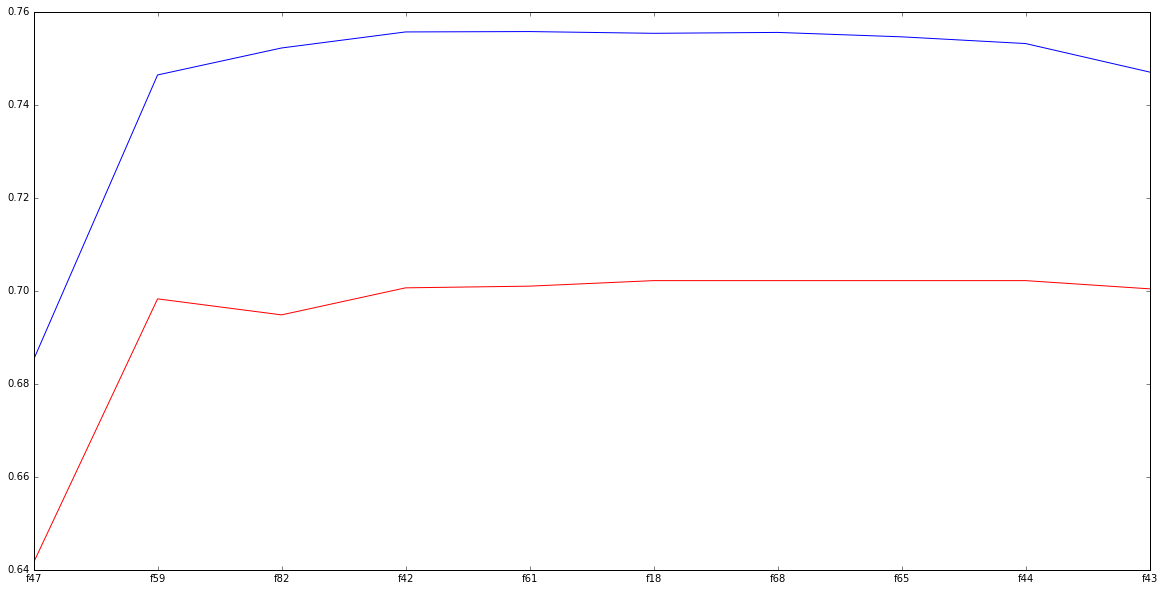

In [155]:
plt.figure(figsize=(20,10))
plt.plot(b,'b')
plt.plot(c,'r')
_=plt.xticks(range(len(a)), a)

['f47', 'f59', 'f82', 'f42', 'f61', 'f18', 'f68', 'f65', 'f44', 'f43']